In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf

torch threads 1
Running on device cpu


In [2]:
import torch
import pyro

import pyro.distributions as dist

import os
from scipy.io import loadmat
from scipy.stats import ttest_1samp
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
import json
import gc

In [3]:
results_folder = "results"
simulation_folder = os.path.join(results_folder, "simulations")
cross_fitting_folder = os.path.join(results_folder, "cross_fitting")
confusion_folder = os.path.join(results_folder, "confusion_matrix")
recovery_folder = os.path.join(results_folder, "recovery")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join(results_folder, "processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

n_agents = 188

In [4]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, "rb") as f:
    all_mask = pickle.load(f)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.9766)


/tmp/ipykernel_3659/1544998221.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  exp_mask = torch.tensor(all_mask).permute((1,0))


In [5]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

In [6]:
def load_simulated_data(base_dir, agent_type):
    print("loading simulated outputs...")

    stayed_arr, true_vals, data = tu.load_simulation_outputs(base_dir, agent_type)

    n_true = true_vals["subject"].max() + 1
    n_data = data["subject"].max() + 1

    assert n_true == n_data == n_agents, f"the numbers of agents dont match! They are: {n_true}, {n_data}, {n_agents}. Probably rerun simulations to fix."

    print("true values are:")
    print(true_vals)

    return true_vals, data

In [7]:
def load_BCC_results(infer_h, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [8]:
def load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    mfmb_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [9]:
def calculate_log_likelihood(data, agent, locs_df, npars, trials, T):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # this is the likelihood of the average parameter

    n_agents = data["actions"].shape[-1]
    log_like = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))

                log_like += torch.log(masked_probs)

    return log_like.clone().detach()
    

In [10]:
def calculate_BIC(data, agent, locs_df, npars, trials, T):

    # use bic to circumvent the number of trials problem

    n_agents = data["actions"].shape[-1]
    BIC = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor(0.5))

                print(masked_probs.shape)

                BIC -= 2*torch.log(masked_probs)

    # question: is it noraml that the first term of the BIC (k*ln(n)) is much smaller than the second (-2*ln(L))?
    BIC += npars*torch.log(data["valid"].sum(axis=0))

    return BIC
    

In [11]:
def calculate_lppd(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (4,5) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average likelihood

    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)

    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    mean_log_like = torch.log(mean_like).sum(dim=0)

    #print(mean_log_like)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    return mean_log_like.clone().detach()
    

In [12]:
def calculate_waic(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (12,13) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average WAIC
    # are the larger number of params handled correctly?

    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)



    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like_samples = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    lppd = torch.log(mean_like_samples).sum(dim=0)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    mean_log_like_samples = torch.log(mean_like.sum(dim=-2)) / n_samples

    V_s = ((torch.log(mean_like) - mean_log_like_samples[:,None,:])**2).sum(dim=-2) / (n_samples-1)

    p_waic = V_s.sum(dim=0)

    ellp_waic = lppd - p_waic

    # text says it needs to be -2 * eq 13.
    # minus is required to make lower better, and the 2 converts it to variance scale

    return ellp_waic.clone().detach()
    

In [13]:
def predictive_accuracy_mean_param(data, agent, locs_df, npars, trials, T):

    n_agents = data["actions"].shape[-1]

    predicted_accuracy = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    num_valid_responses = torch.zeros(data["actions"].shape[-1])

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:
                #print(tau,t)

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]#*data["valid"][tau].long()
                #print(curr_response)

                predicted_response = torch.argmax(probs, dim=0)[0]

                #print(probs)

                #print(predicted_response)

                correct_response_predicted = (curr_response == predicted_response).int()

                #print(correct_response_predicted)

                predicted_accuracy += correct_response_predicted

                num_valid_responses += data["valid"][tau]

                #print(num_valid_responses)


    corrected_predicted_accuracy = predicted_accuracy / num_valid_responses

    return corrected_predicted_accuracy

In [14]:
def calculate_exceedance_prob(measure, n_exc_samples=500):
    
    p_model = torch.nn.functional.softmax(measure, dim=-1)

    print("p model mean according to measure", p_model.mean(dim=0))

    dirichlet_counts = p_model.sum(dim=0)

    model_prob_dirichlet = dist.Dirichlet(dirichlet_counts)

    n_exc_samples = 500

    dir_samples = model_prob_dirichlet.sample(sample_shape=torch.tensor([n_exc_samples]))

    avg_best_model = dir_samples.mean(dim=0).argmax()

    best_model = dir_samples.argmax(dim=1)

    exc_prob = (best_model == avg_best_model).sum()/n_exc_samples

    print("best model:", avg_best_model, "exceedance prob", exc_prob)

    significant_best_model = ttest_1samp(dir_samples[:,avg_best_model], 1./measure.shape[-1], alternative="greater")

    print("is significantly different from uniform?", significant_best_model)

# 1. True agent = BCC3

In [15]:
# load BCC3 data

BCC3_infer_h = False

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if BCC3_infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC3_param_names = param_names.copy()

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for loading results
# make base filename and folder string
BCC3_agent_type = prefix+h_str
BCC3_data_fname_base = prefix+h_str+"_simulation_"
print(BCC3_data_fname_base)
# define folder where we want to save data
BCC3_data_base_dir = os.path.join(simulation_folder,BCC3_data_fname_base[:-1])

BCC3_true_vals, BCC3_data = load_simulated_data(BCC3_data_base_dir, BCC3_agent_type)

BCC_3param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 1

BCC_3param_recovery_
analyzing 188 data sets


/home/sarah/src/BayesianTwoStageTaskAnalysis/code/BalancingControl/perception.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699116133598/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


<Figure size 640x480 with 0 Axes>

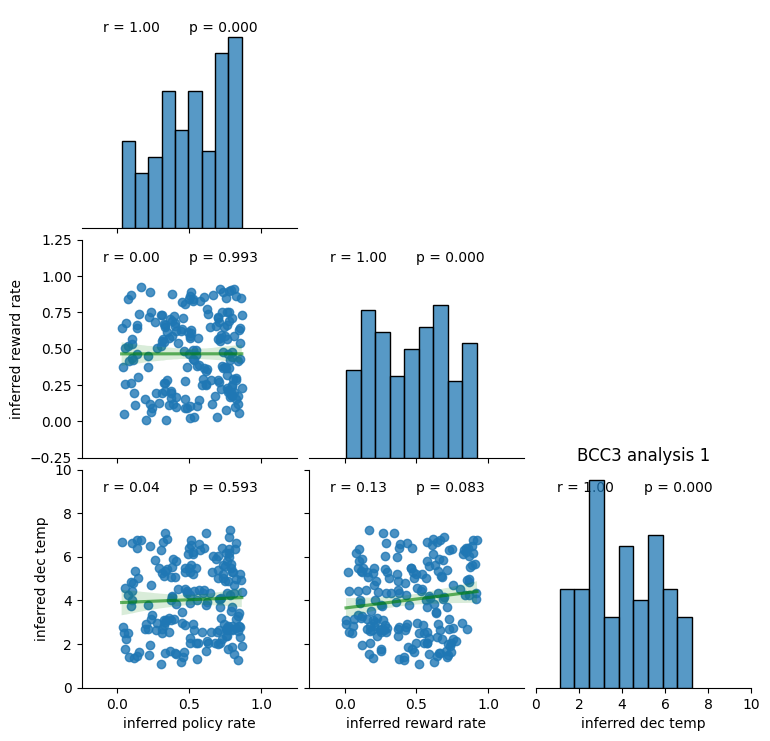

In [16]:
# load BCC3 fitting of BCC3 data

BCC3_BCC3_fname_base = BCC3_agent_type+"_recovery_"
print(BCC3_BCC3_fname_base)
# define folder where we want to save data
BCC3_BCC3_base_dir = os.path.join(recovery_folder,BCC3_BCC3_fname_base[:-1])

num_steps = 600

BCC3_BCC3_mean_df, BCC3_BCC3_sample_df, BCC3_BCC3_locs_df = load_BCC_results(BCC3_infer_h, BCC3_BCC3_base_dir, 
                                                                             global_experiment_parameters, exp_mask, BCC3_BCC3_fname_base, 
                                                                             num_steps, BCC3_data, BCC3_param_names)
BCC3_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, BCC3_BCC3_base_dir, global_experiment_parameters, 
                                                     BCC3_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=BCC3_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


In [17]:
# BCC4 agent

BCC4_infer_h = True

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if BCC4_infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC4_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for loading results
# make base filename and folder string
BCC4_agent_type = prefix+h_str
BCC4_data_fname_base = prefix+h_str+"_simulation_"
print(BCC4_data_fname_base)
# define folder where we want to save data
BCC4_data_base_dir = os.path.join(simulation_folder,BCC4_data_fname_base[:-1])

BCC4_true_vals, BCC4_data = load_simulated_data(BCC4_data_base_dir, BCC4_agent_type)

BCC_4param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 1

BCC3param_cross_fitting_BCC_4param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

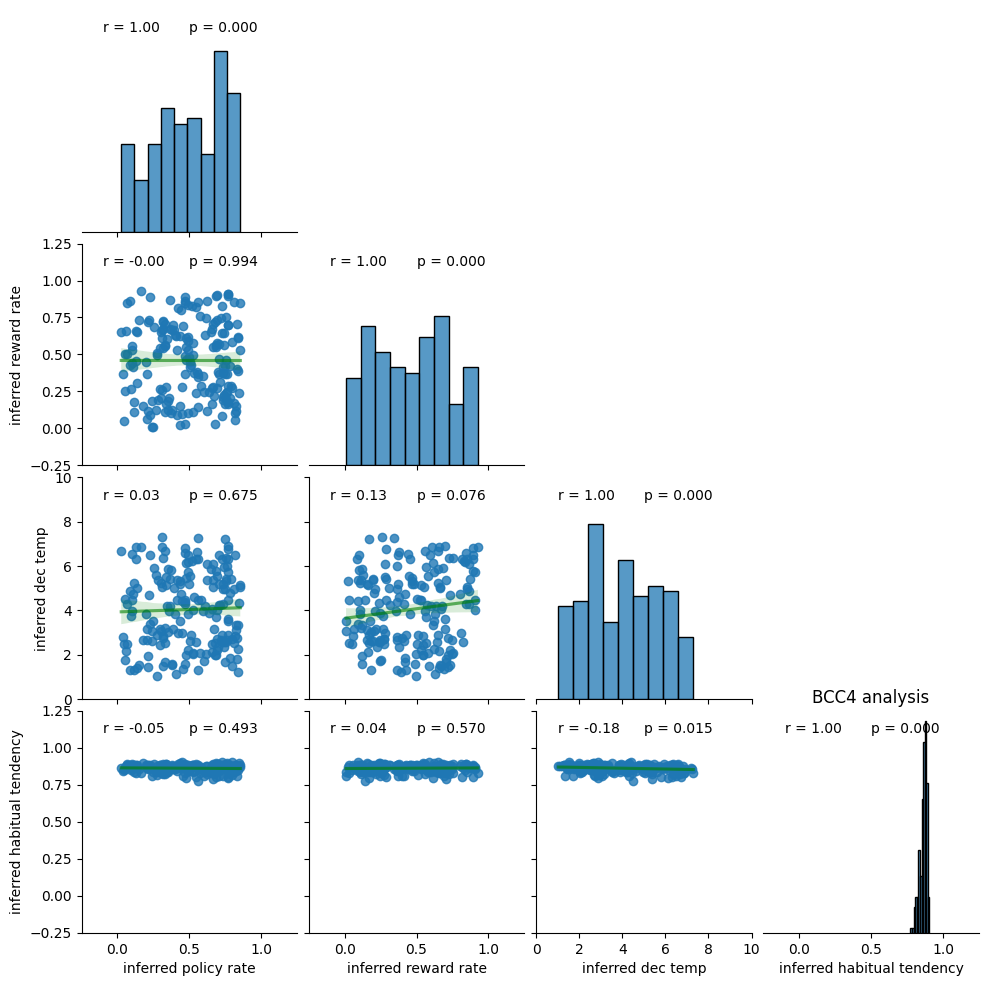

In [18]:
BCC3_BCC4_fname_base = "BCC3param_cross_fitting_"+BCC4_agent_type
print(BCC3_BCC4_fname_base)
# define folder where we want to save data
BCC3_BCC4_base_dir = os.path.join(cross_fitting_folder,BCC3_BCC4_fname_base[:-1])

num_steps = 600

BCC3_BCC4_mean_df, BCC3_BCC4_sample_df, BCC3_BCC4_locs_df = load_BCC_results(BCC4_infer_h, BCC3_BCC4_base_dir, 
                                                                             global_experiment_parameters, exp_mask, 
                                                                             BCC3_BCC4_fname_base, num_steps, BCC3_data, BCC4_param_names)
BCC3_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, BCC3_BCC4_base_dir, 
                                                     global_experiment_parameters, BCC3_data["valid"], remove_old=False)

BCC4_param_ranges = [[0,1], [0,1], [0,max_dt], [0,1]]
BCC4_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10], [-0.25,1.25]]
BCC4_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


In [19]:
# MFMB4 analysis

# set parameters and their names

use_orig = False

MFMB4_use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if MFMB4_use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB4_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
MFMB4_agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

MFMB4_data_fname_base = MFMB4_agent_type+"_simulation_"
print(MFMB4_data_fname_base)
# define folder where we want to save data
MFMB4_data_base_dir = os.path.join(simulation_folder,MFMB4_data_fname_base[:-1])

MFMB4_true_vals, MFMB4_data = load_simulated_data(MFMB4_data_base_dir, MFMB4_agent_type)

mbmf_4param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 

BCC3param_cross_fitting_mbmf_4param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

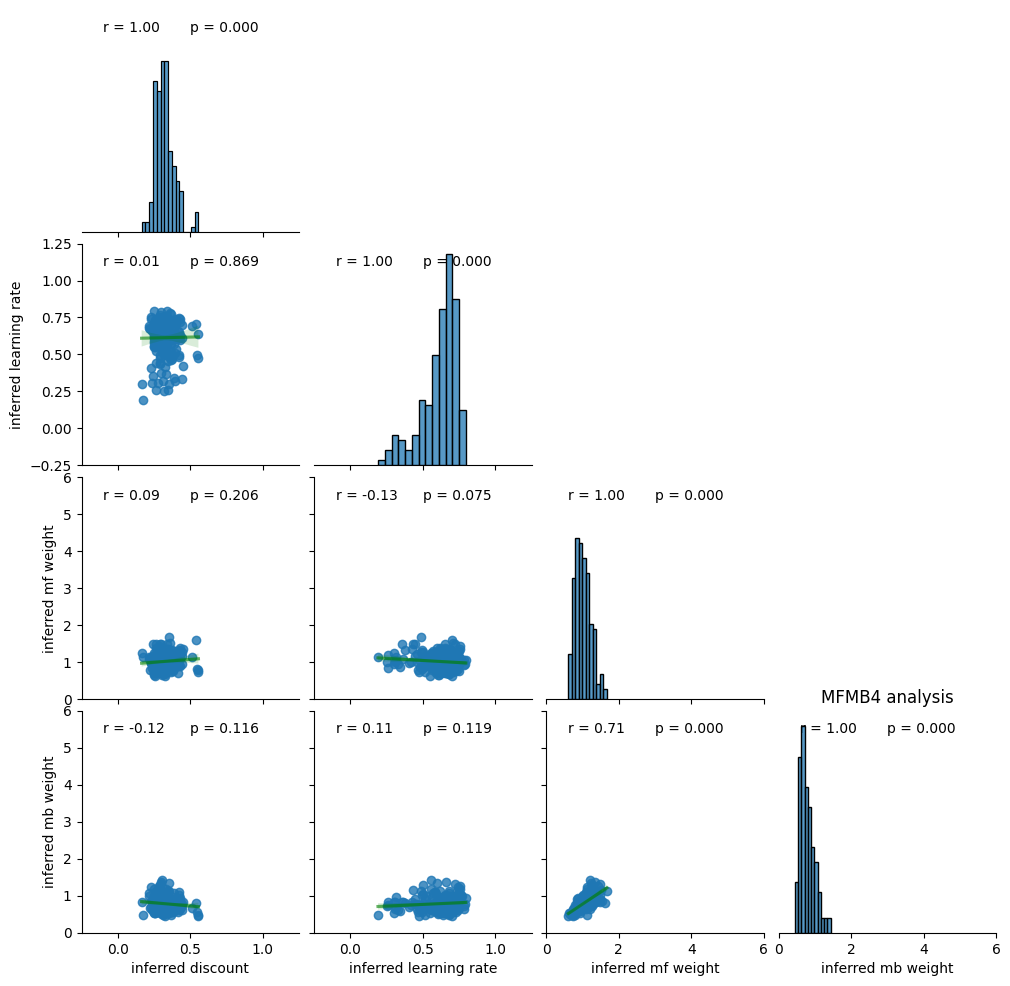

In [20]:
# prepare for saving results
# make base filename and folder string
BCC3_MFMB4_fname_base = "BCC3param_cross_fitting_"+MFMB4_agent_type
print(BCC3_MFMB4_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC3_MFMB4_base_dir = os.path.join(cross_fitting_folder,BCC3_MFMB4_fname_base[:-1])

num_steps = 500

BCC3_MFMB4_mean_df, BCC3_MFMB4_sample_df, BCC3_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, 
                                                                                 BCC3_MFMB4_base_dir, global_experiment_parameters, 
                                                                                 BCC3_data["valid"], BCC3_MFMB4_fname_base, num_steps, 
                                                                                 BCC3_data, MFMB4_param_names)

BCC3_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, 
                                                  restrict_alpha, max_dt, min_alpha, 
                                                  BCC3_MFMB4_base_dir, global_experiment_parameters, 
                                                  BCC3_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=BCC3_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

In [21]:
# MFMB5 analysis

# set parameters and their names

use_orig = False

MFMB5_use_p = True
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if MFMB5_use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB5_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
MFMB5_agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

MFMB5_data_fname_base = MFMB5_agent_type+"_simulation_"
print(MFMB5_data_fname_base)
# define folder where we want to save data
MFMB5_data_base_dir = os.path.join(simulation_folder,MFMB5_data_fname_base[:-1])

MFMB5_true_vals, MFMB5_data = load_simulated_data(MFMB5_data_base_dir, MFMB5_agent_type)

mbmf_5param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 

BCC3param_cross_fitting_mbmf_5param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

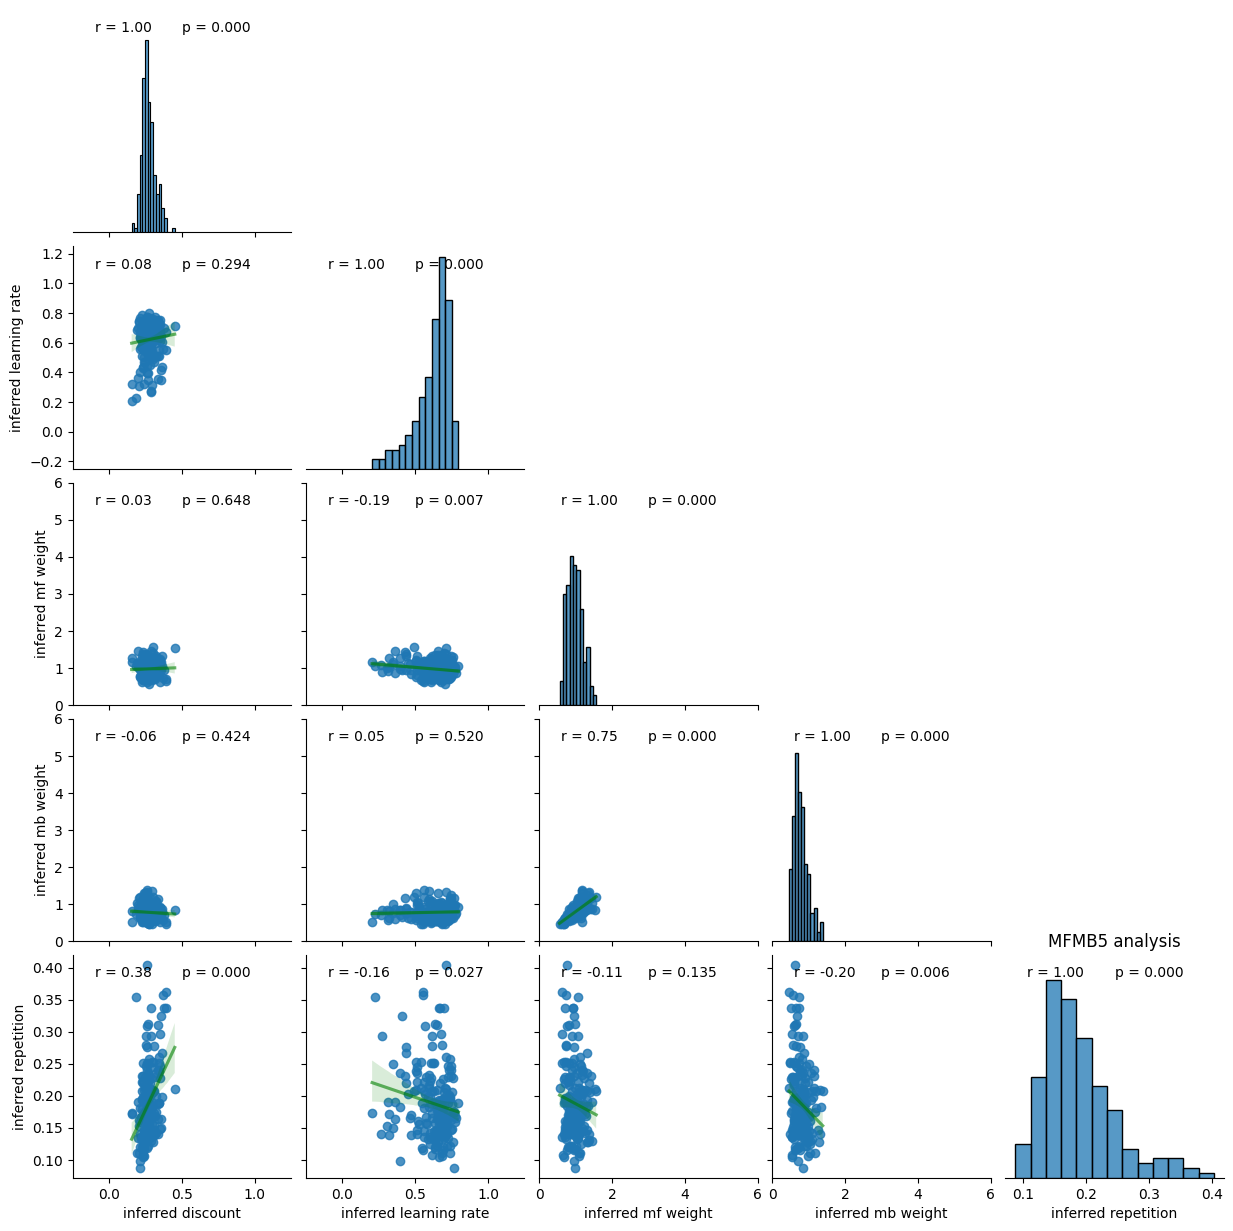

In [22]:
# prepare for saving results
# make base filename and folder string
BCC3_MFMB5_fname_base = "BCC3param_cross_fitting_"+MFMB5_agent_type
print(BCC3_MFMB5_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC3_MFMB5_base_dir = os.path.join(cross_fitting_folder,BCC3_MFMB5_fname_base[:-1])

num_steps = 500

BCC3_MFMB5_mean_df, BCC3_MFMB5_sample_df, BCC3_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, 
                                                                                 restrict_alpha, max_dt, BCC3_MFMB5_base_dir, 
                                                                                 global_experiment_parameters, BCC3_data["valid"], 
                                                                                 BCC3_MFMB5_fname_base, num_steps, BCC3_data, MFMB5_param_names)

BCC3_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, 
                                                  max_dt, min_alpha, BCC3_MFMB5_base_dir, global_experiment_parameters, 
                                                  BCC3_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# 2. BCC4 Data

BCC4param_cross_fitting_BCC_3param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

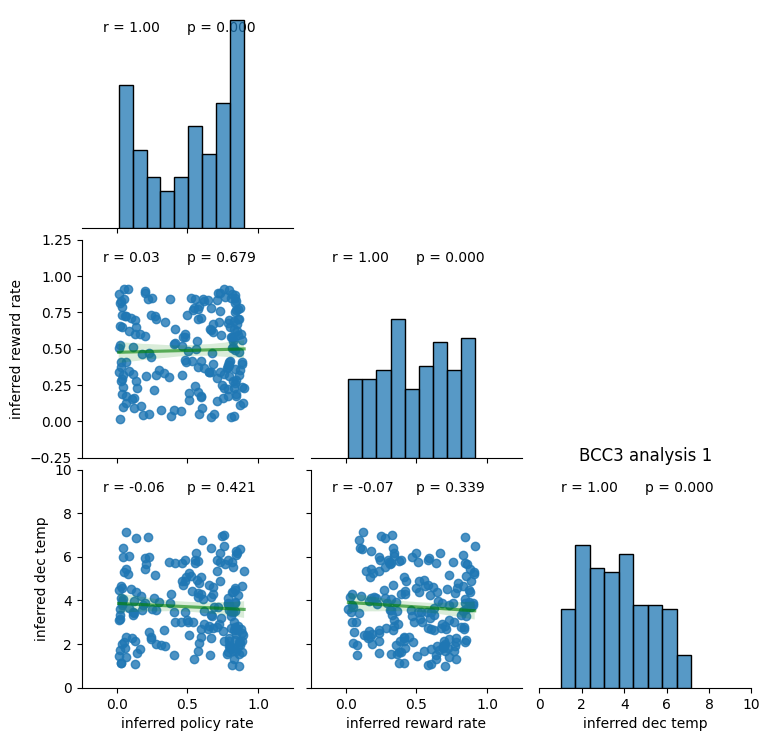

In [23]:
# load BCC3 fitting of BCC4 data

BCC4_BCC3_fname_base = "BCC4param_cross_fitting_"+BCC3_agent_type
print(BCC4_BCC3_fname_base)
# define folder where we want to save data
BCC4_BCC3_base_dir = os.path.join(cross_fitting_folder,BCC4_BCC3_fname_base[:-1])

num_steps = 600

BCC4_BCC3_mean_df, BCC4_BCC3_sample_df, BCC4_BCC3_locs_df = load_BCC_results(BCC3_infer_h, BCC4_BCC3_base_dir, 
                                                                             global_experiment_parameters, exp_mask, 
                                                                             BCC4_BCC3_fname_base, num_steps, BCC4_data, BCC3_param_names)
BCC4_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, BCC4_BCC3_base_dir, 
                                                     global_experiment_parameters, BCC4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=BCC4_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

BCC_4param_recovery_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

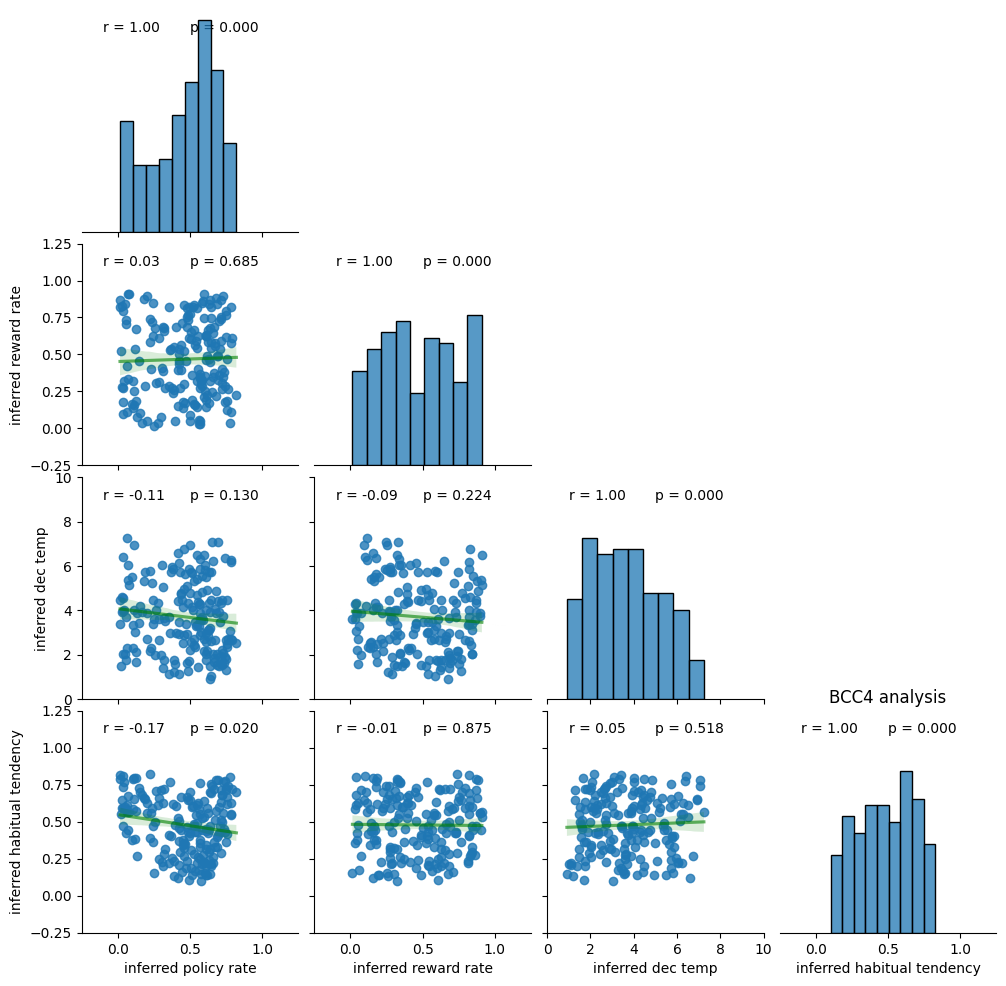

In [24]:
# BCC4 agent for BCC4 data


BCC4_BCC4_fname_base = BCC4_agent_type+"_recovery_"
print(BCC4_BCC4_fname_base)
# define folder where we want to save data
BCC4_BCC4_base_dir = os.path.join(recovery_folder,BCC4_BCC4_fname_base[:-1])

num_steps = 600

BCC4_BCC4_mean_df, BCC4_BCC4_sample_df, BCC4_BCC4_locs_df = load_BCC_results(BCC4_infer_h, BCC4_BCC4_base_dir, 
                                                                             global_experiment_parameters, exp_mask, 
                                                                             BCC4_BCC4_fname_base, num_steps, BCC4_data, BCC4_param_names)
BCC4_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, BCC4_BCC4_base_dir, 
                                                     global_experiment_parameters, BCC4_data["valid"], remove_old=False)

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC4_param_names]
f = sns.pairplot(data=BCC4_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

BCC4param_cross_fitting_mbmf_4param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

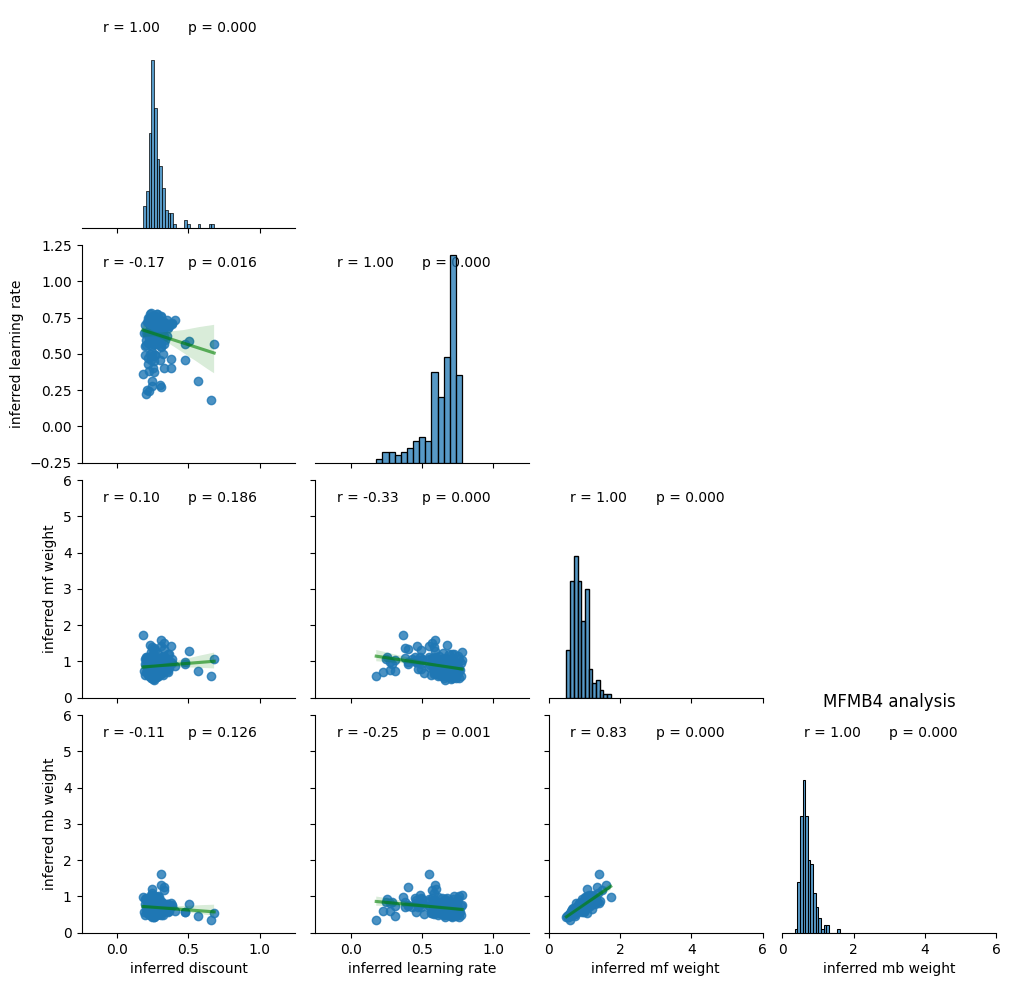

In [25]:
# prepare for saving results
# make base filename and folder string
BCC4_MFMB4_fname_base = "BCC4param_cross_fitting_"+MFMB4_agent_type
print(BCC4_MFMB4_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC4_MFMB4_base_dir = os.path.join(cross_fitting_folder,BCC4_MFMB4_fname_base[:-1])

num_steps = 500

BCC4_MFMB4_mean_df, BCC4_MFMB4_sample_df, BCC4_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, BCC4_MFMB4_base_dir, global_experiment_parameters, BCC4_data["valid"], BCC4_MFMB4_fname_base, num_steps, BCC4_data, MFMB4_param_names)

BCC4_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, restrict_alpha, max_dt, min_alpha, BCC4_MFMB4_base_dir, global_experiment_parameters, BCC4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=BCC4_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

BCC4param_cross_fitting_mbmf_5param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

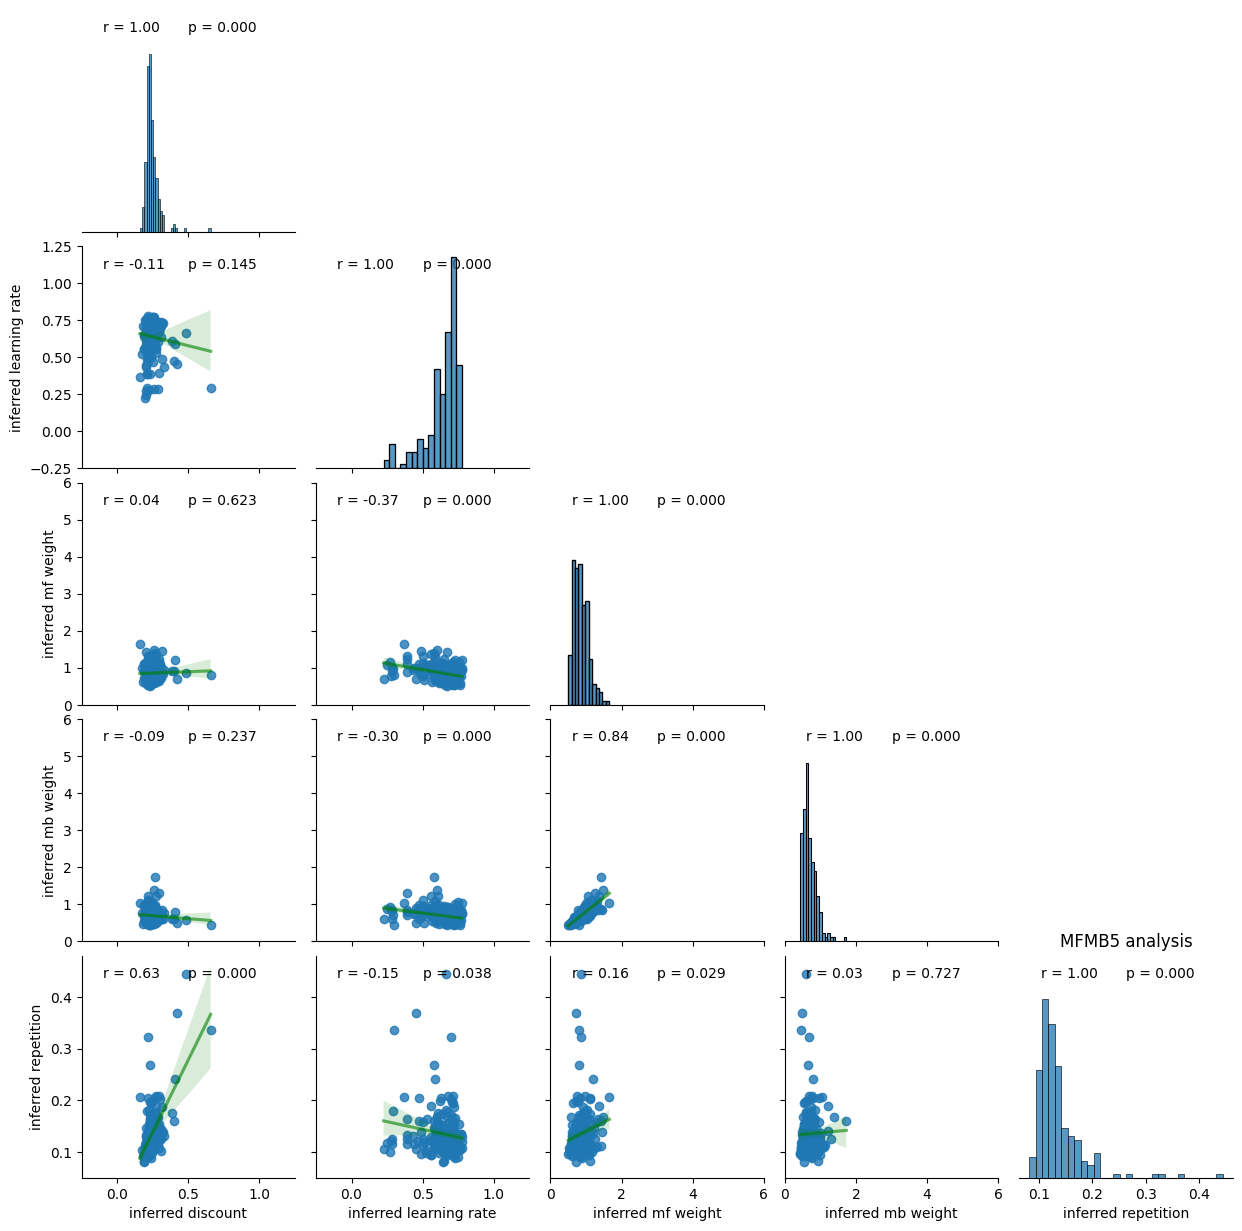

In [26]:
# prepare for saving results
# make base filename and folder string
BCC4_MFMB5_fname_base = "BCC4param_cross_fitting_"+MFMB5_agent_type
print(BCC4_MFMB5_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC4_MFMB5_base_dir = os.path.join(cross_fitting_folder,BCC4_MFMB5_fname_base[:-1])

num_steps = 500

BCC4_MFMB5_mean_df, BCC4_MFMB5_sample_df, BCC4_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, restrict_alpha, 
                                                                                 max_dt, BCC4_MFMB5_base_dir, 
                                                                                 global_experiment_parameters, BCC4_data["valid"], 
                                                                                 BCC4_MFMB5_fname_base, num_steps, BCC4_data, MFMB5_param_names)

BCC4_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, max_dt, 
                                                  min_alpha, BCC4_MFMB5_base_dir, global_experiment_parameters, 
                                                  BCC4_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB5_param_names]
f = sns.pairplot(data=BCC4_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# 3. MFMB4 data

MFMB4param_cross_fitting_BCC_3param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

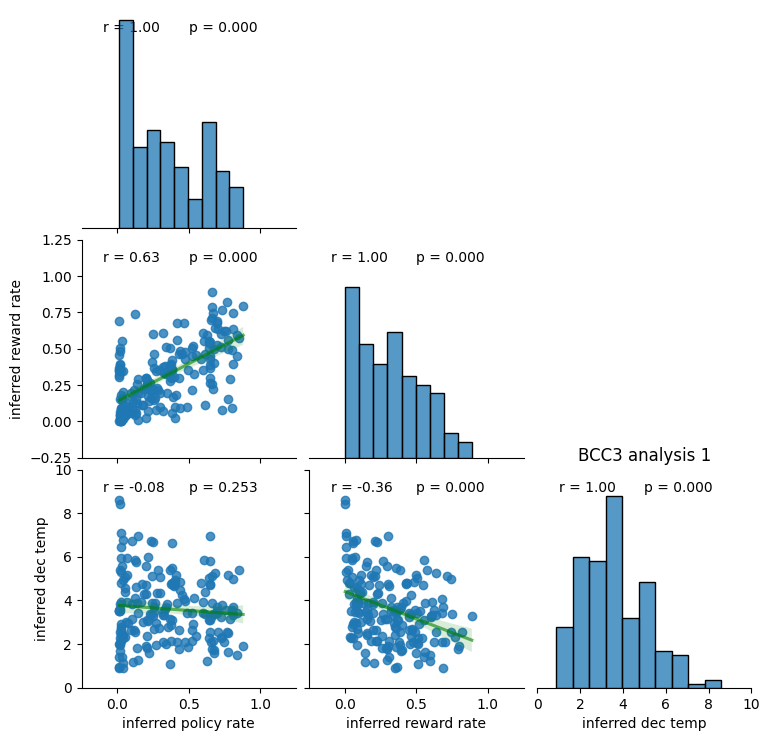

In [27]:
# load BCC3 fitting of MFMB4 data

MFMB4_BCC3_fname_base = "MFMB4param_cross_fitting_"+BCC3_agent_type
print(MFMB4_BCC3_fname_base)
# define folder where we want to save data
MFMB4_BCC3_base_dir = os.path.join(cross_fitting_folder,MFMB4_BCC3_fname_base[:-1])

num_steps = 600

MFMB4_BCC3_mean_df, MFMB4_BCC3_sample_df, MFMB4_BCC3_locs_df = load_BCC_results(BCC3_infer_h, MFMB4_BCC3_base_dir, 
                                                                                global_experiment_parameters, exp_mask, MFMB4_BCC3_fname_base, 
                                                                                num_steps, MFMB4_data, BCC3_param_names)
MFMB4_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, MFMB4_BCC3_base_dir, global_experiment_parameters, 
                                                      MFMB4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=MFMB4_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB4param_cross_fitting_BCC_4param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

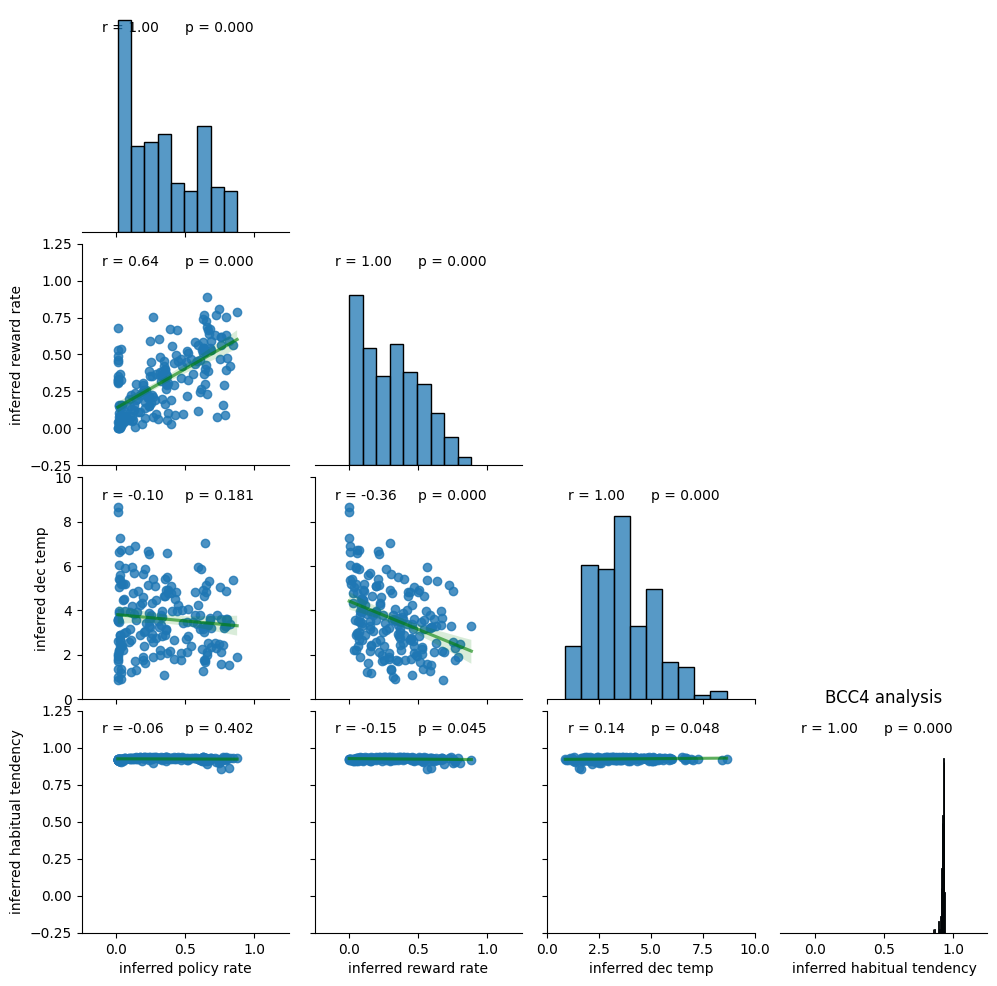

In [28]:
# BCC4 agent for MFMB4 data


MFMB4_BCC4_fname_base = "MFMB4param_cross_fitting_"+BCC4_agent_type
print(MFMB4_BCC4_fname_base)
# define folder where we want to save data
MFMB4_BCC4_base_dir = os.path.join(cross_fitting_folder,MFMB4_BCC4_fname_base[:-1])

num_steps = 600

MFMB4_BCC4_mean_df, MFMB4_BCC4_sample_df, MFMB4_BCC4_locs_df = load_BCC_results(BCC4_infer_h, MFMB4_BCC4_base_dir, 
                                                                                global_experiment_parameters, exp_mask, 
                                                                                MFMB4_BCC4_fname_base, num_steps, MFMB4_data, BCC4_param_names)
MFMB4_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, MFMB4_BCC4_base_dir, global_experiment_parameters, 
                                                      MFMB4_data["valid"], remove_old=False)

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC4_param_names]
f = sns.pairplot(data=MFMB4_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

mbmf_4param_recovery_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

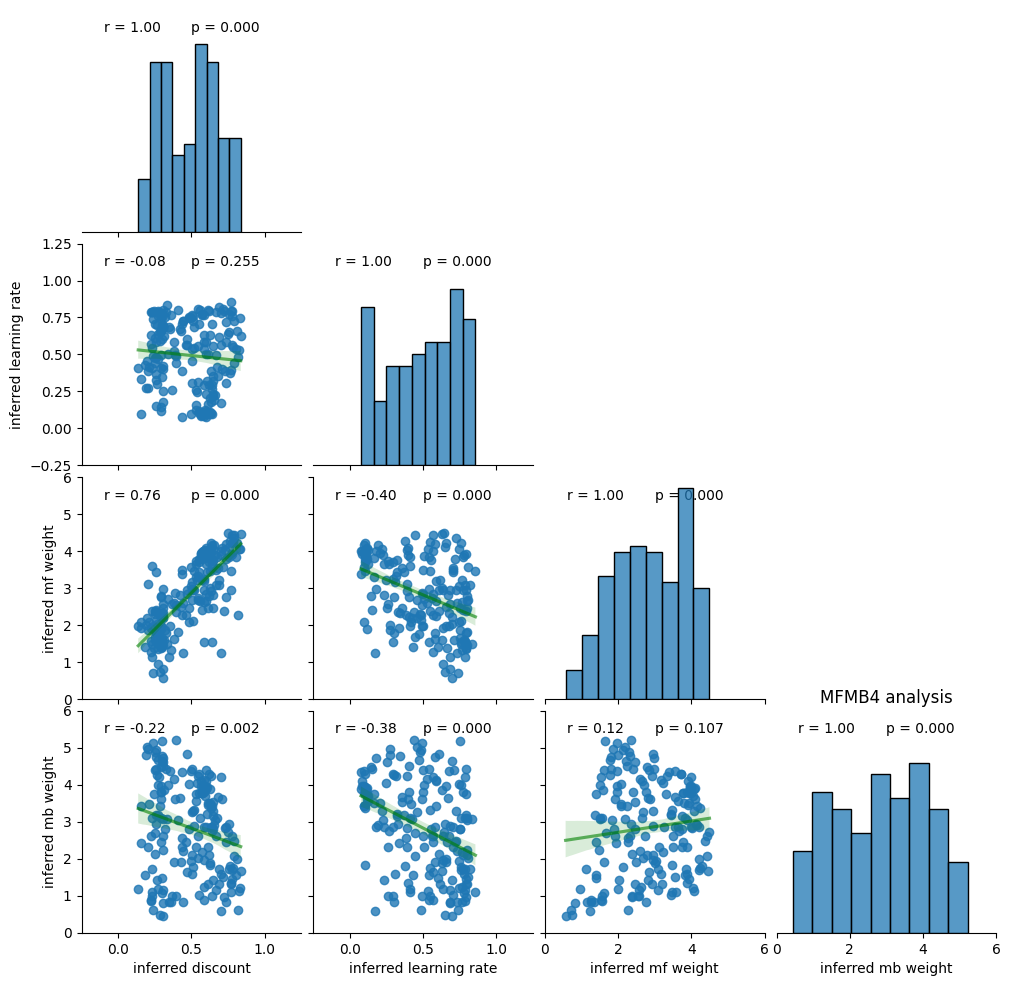

In [29]:
# prepare for saving results
# make base filename and folder string
MFMB4_MFMB4_fname_base = MFMB4_agent_type+"_recovery_"
print(MFMB4_MFMB4_fname_base)
# define folder where we want to save data
MFMB4_MFMB4_base_dir = os.path.join(recovery_folder,MFMB4_MFMB4_fname_base[:-1])

num_steps = 500

MFMB4_MFMB4_mean_df, MFMB4_MFMB4_sample_df, MFMB4_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, 
                                                                                    MFMB4_MFMB4_base_dir, global_experiment_parameters, 
                                                                                    MFMB4_data["valid"], MFMB4_MFMB4_fname_base, num_steps, 
                                                                                    MFMB4_data, MFMB4_param_names)

MFMB4_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, restrict_alpha, max_dt, min_alpha, 
                                                   MFMB4_MFMB4_base_dir, global_experiment_parameters, 
                                                   MFMB4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=MFMB4_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB4param_cross_fitting_mbmf_5param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

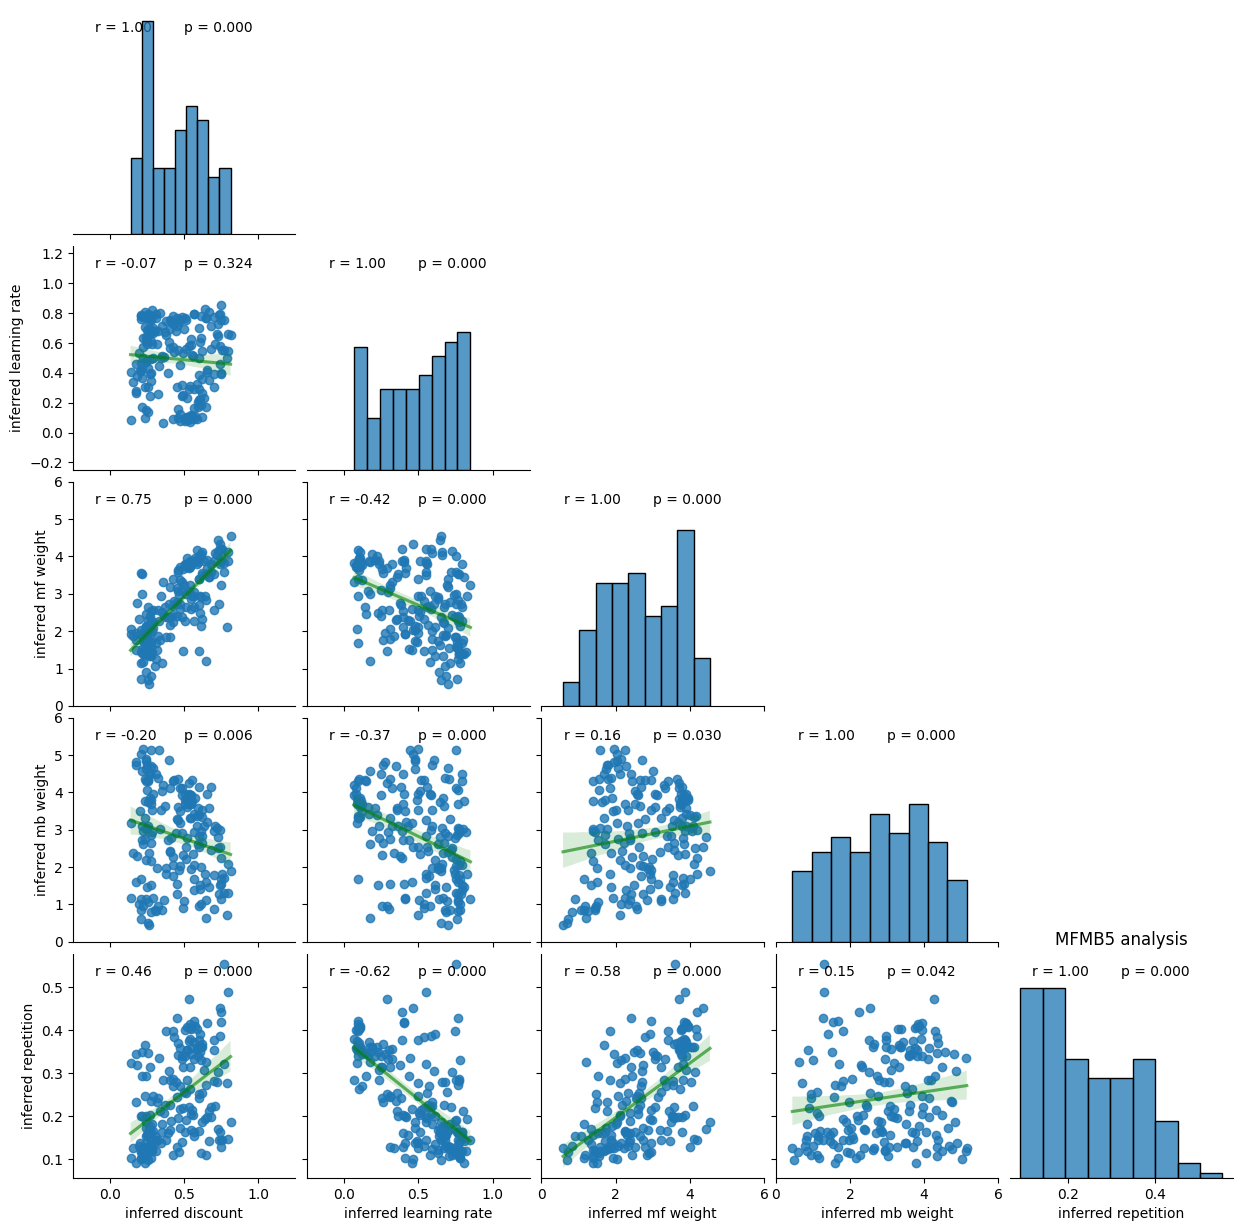

In [30]:
# prepare for saving results
# make base filename and folder string
MFMB4_MFMB5_fname_base = "MFMB4param_cross_fitting_"+MFMB5_agent_type
print(MFMB4_MFMB5_fname_base)
# define folder where we want to save data
# make base filename and folder string
MFMB4_MFMB5_base_dir = os.path.join(cross_fitting_folder,MFMB4_MFMB5_fname_base[:-1])

num_steps = 500

MFMB4_MFMB5_mean_df, MFMB4_MFMB5_sample_df, MFMB4_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, 
                                                                                    restrict_alpha, max_dt, MFMB4_MFMB5_base_dir, 
                                                                                    global_experiment_parameters, MFMB4_data["valid"], 
                                                                                    MFMB4_MFMB5_fname_base, num_steps, MFMB4_data, MFMB4_param_names)

MFMB4_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, max_dt, 
                                                   min_alpha, MFMB4_MFMB5_base_dir, global_experiment_parameters, 
                                                   MFMB4_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB5_param_names]
f = sns.pairplot(data=MFMB4_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# 4. MFMB5 data

MFMB5param_cross_fitting_BCC_3param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

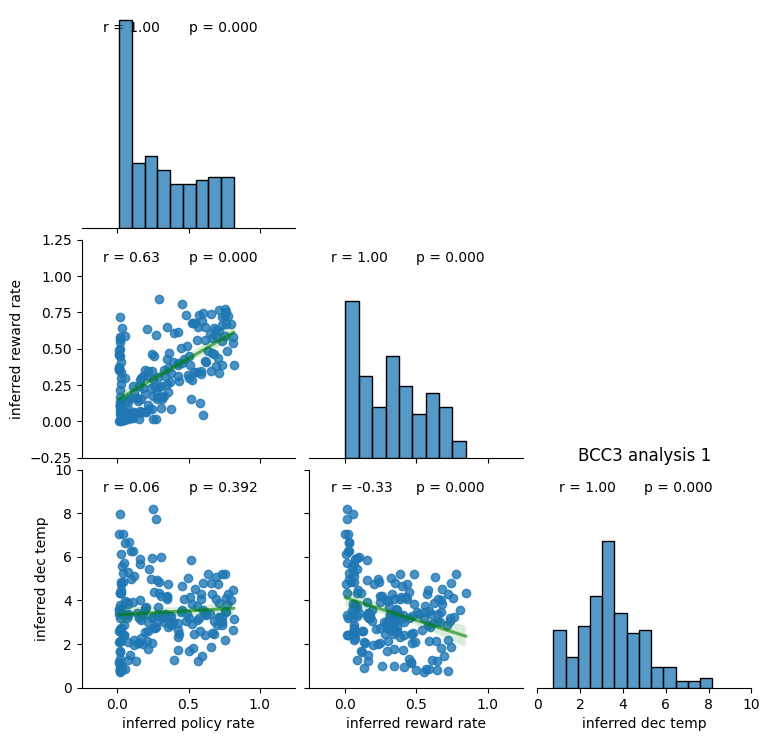

In [31]:
# load BCC3 fitting of MFMB5 data

MFMB5_BCC3_fname_base = "MFMB5param_cross_fitting_"+BCC3_agent_type
print(MFMB5_BCC3_fname_base)
# define folder where we want to save data
MFMB5_BCC3_base_dir = os.path.join(cross_fitting_folder,MFMB5_BCC3_fname_base[:-1])

num_steps = 600

MFMB5_BCC3_mean_df, MFMB5_BCC3_sample_df, MFMB5_BCC3_locs_df = load_BCC_results(BCC3_infer_h, MFMB5_BCC3_base_dir, 
                                                                                global_experiment_parameters, exp_mask, 
                                                                                MFMB5_BCC3_fname_base, num_steps, 
                                                                                MFMB5_data, BCC3_param_names)
MFMB5_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, MFMB5_BCC3_base_dir, global_experiment_parameters, 
                                                      MFMB5_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=MFMB5_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB5param_cross_fitting_BCC_4param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

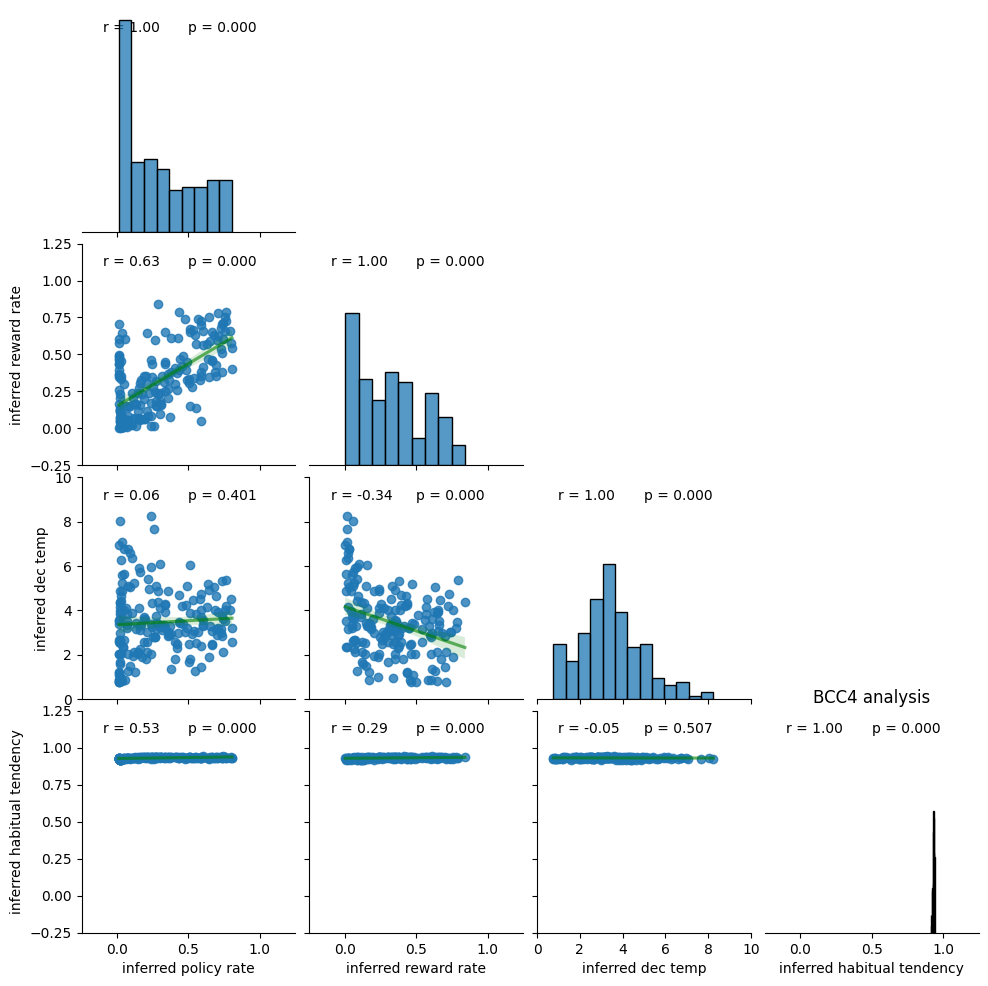

In [32]:
# BCC4 agent for MFMB5 data


MFMB5_BCC4_fname_base = "MFMB5param_cross_fitting_"+BCC4_agent_type
print(MFMB5_BCC4_fname_base)
# define folder where we want to save data
MFMB5_BCC4_base_dir = os.path.join(cross_fitting_folder,MFMB5_BCC4_fname_base[:-1])

num_steps = 600

MFMB5_BCC4_mean_df, MFMB5_BCC4_sample_df, MFMB5_BCC4_locs_df = load_BCC_results(BCC4_infer_h, MFMB5_BCC4_base_dir, 
                                                                                global_experiment_parameters, exp_mask, 
                                                                                MFMB5_BCC4_fname_base, num_steps, 
                                                                                MFMB5_data, BCC4_param_names)
MFMB5_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, MFMB5_BCC4_base_dir, global_experiment_parameters, 
                                                      MFMB5_data["valid"], remove_old=False)

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC4_param_names]
f = sns.pairplot(data=MFMB5_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB5param_cross_fitting_mbmf_4param
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

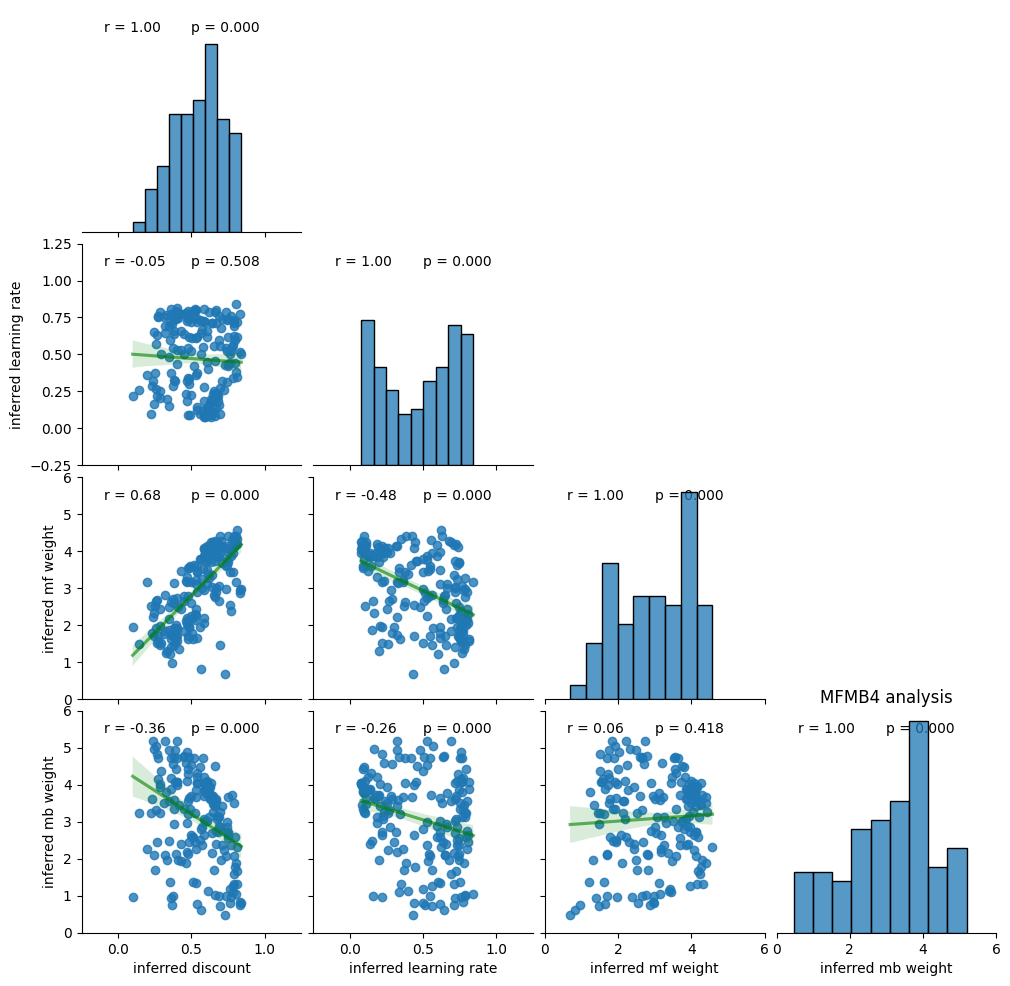

In [33]:
# prepare for saving results
# make base filename and folder string
MFMB5_MFMB4_fname_base = "MFMB5param_cross_fitting_"+MFMB4_agent_type
print(MFMB5_MFMB4_fname_base)
# define folder where we want to save data
# make base filename and folder string
MFMB5_MFMB4_base_dir = os.path.join(cross_fitting_folder,MFMB5_MFMB4_fname_base[:-1])

num_steps = 500

MFMB5_MFMB4_mean_df, MFMB5_MFMB4_sample_df, MFMB5_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, 
                                                                                    MFMB5_MFMB4_base_dir, global_experiment_parameters, 
                                                                                    MFMB5_data["valid"], MFMB5_MFMB4_fname_base, num_steps, 
                                                                                    MFMB5_data, MFMB4_param_names)

MFMB5_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, restrict_alpha, max_dt, min_alpha, 
                                                   MFMB5_MFMB4_base_dir, global_experiment_parameters, MFMB5_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=MFMB5_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

mbmf_5param_recovery_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

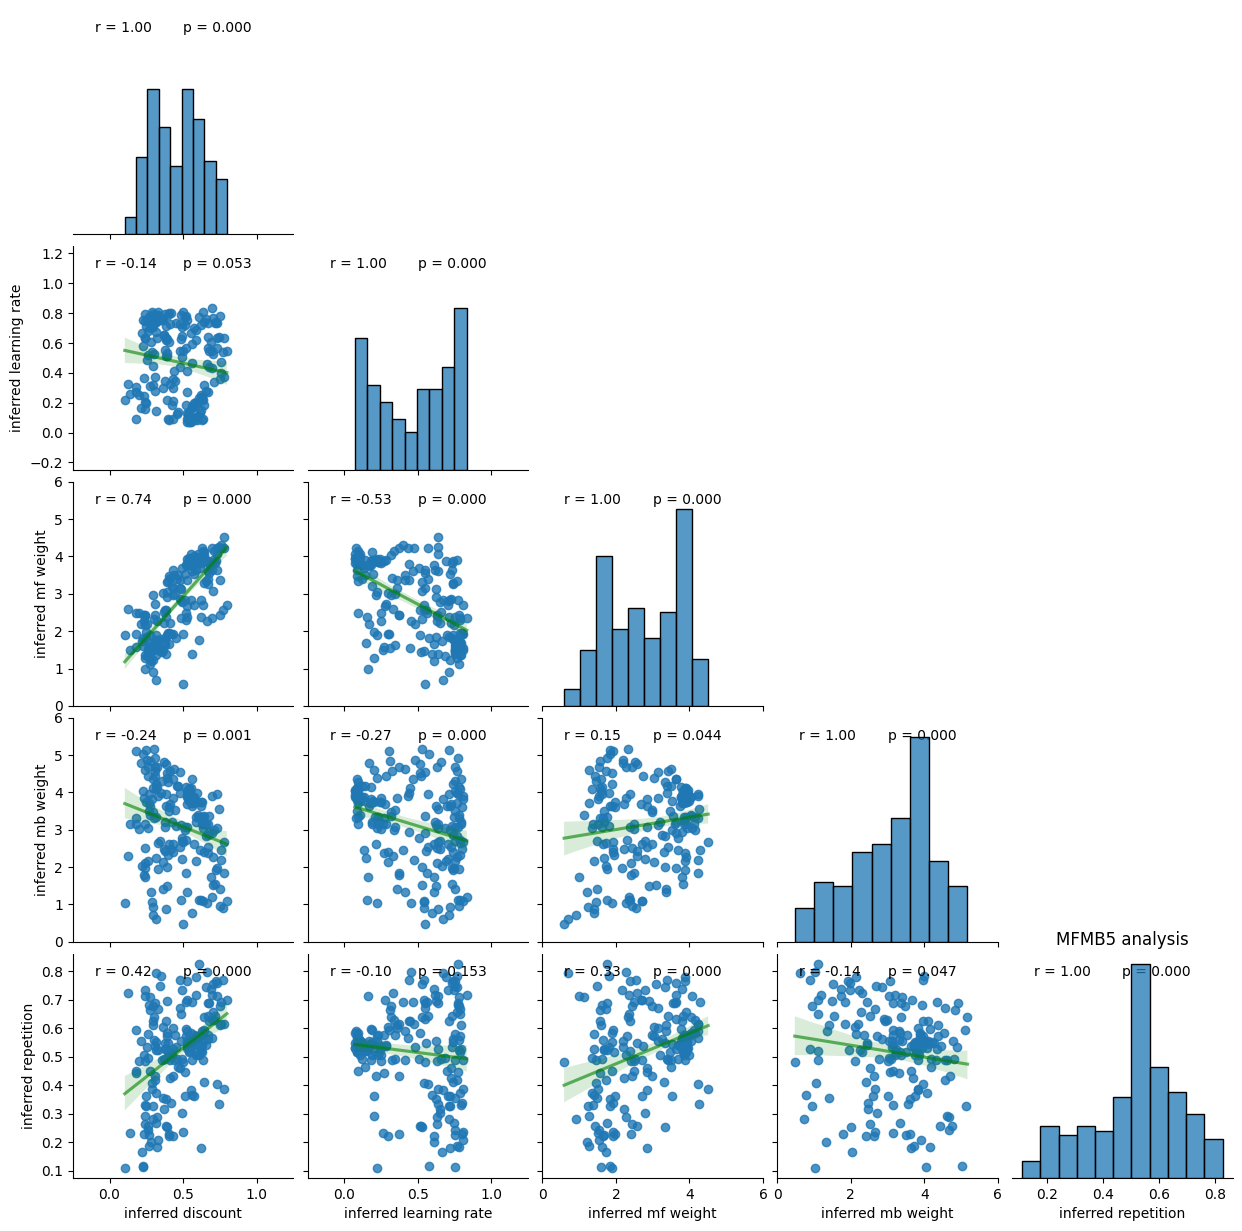

In [34]:
# prepare for saving results
# make base filename and folder string
MFMB5_MFMB5_fname_base = MFMB5_agent_type+"_recovery_"
print(MFMB5_MFMB5_fname_base)
# define folder where we want to save data
MFMB5_MFMB5_base_dir = os.path.join(recovery_folder,MFMB5_MFMB5_fname_base[:-1])

num_steps = 500

MFMB5_MFMB5_mean_df, MFMB5_MFMB5_sample_df, MFMB5_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, 
                                                                                    restrict_alpha, max_dt, MFMB5_MFMB5_base_dir, 
                                                                                    global_experiment_parameters, MFMB5_data["valid"], 
                                                                                    MFMB5_MFMB5_fname_base, num_steps, MFMB5_data, MFMB4_param_names)

MFMB5_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, max_dt, min_alpha, 
                                                   MFMB5_MFMB5_base_dir, global_experiment_parameters, MFMB5_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB5_param_names]
f = sns.pairplot(data=MFMB5_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# Get all WAICs

In [35]:
# BCC3 data

BCC3_BCC3_WAIC = -calculate_waic(BCC3_data, BCC3_BCC3_agent, BCC3_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_BCC4_WAIC = -calculate_waic(BCC3_data, BCC3_BCC4_agent, BCC3_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_MFMB4_WAIC = -calculate_waic(BCC3_data, BCC3_MFMB4_agent, BCC3_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_MFMB5_WAIC = -calculate_waic(BCC3_data, BCC3_MFMB5_agent, BCC3_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [36]:
BCC3_data_all_total_WAICs = torch.stack([BCC3_BCC3_WAIC, BCC3_BCC4_WAIC, BCC3_MFMB4_WAIC, BCC3_MFMB5_WAIC], dim=-1)

winning_model = BCC3_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*BCC3_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC3_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC3_data_all_total_WAICs)

BCC3 wins tensor(32)
BCC4 wins tensor(155)
MFMB4 wins tensor(0)
MFMB5 wins tensor(1)
torch.Size([188, 4])
tensor([1.9169e-01, 8.0166e-01, 6.2292e-04, 6.0256e-03])
tensor([0., 1., 0., 0.])
p model mean according to measure tensor([1.9169e-01, 8.0166e-01, 6.2292e-04, 6.0256e-03])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=421.16134721568307, pvalue=0.0, df=499)


In [37]:
# BCC4 data

BCC4_BCC3_WAIC = -calculate_waic(BCC4_data, BCC4_BCC3_agent, BCC4_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_BCC4_WAIC = -calculate_waic(BCC4_data, BCC4_BCC4_agent, BCC4_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_MFMB4_WAIC = -calculate_waic(BCC4_data, BCC4_MFMB4_agent, BCC4_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_MFMB5_WAIC = -calculate_waic(BCC4_data, BCC4_MFMB5_agent, BCC4_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [38]:
BCC4_data_all_total_WAICs = torch.stack([BCC4_BCC3_WAIC, BCC4_BCC4_WAIC, BCC4_MFMB4_WAIC, BCC4_MFMB5_WAIC], dim=-1)

winning_model = BCC4_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*BCC4_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC4_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC4_data_all_total_WAICs)

BCC3 wins tensor(3)
BCC4 wins tensor(184)
MFMB4 wins tensor(1)
MFMB5 wins tensor(0)
torch.Size([188, 4])
tensor([2.0394e-02, 9.7399e-01, 5.5769e-03, 3.4238e-05])
tensor([0., 1., 0., 0.])
p model mean according to measure tensor([2.0394e-02, 9.7399e-01, 5.5769e-03, 3.4238e-05])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=1397.5079035028893, pvalue=0.0, df=499)


In [39]:
# MFMB4 data

MFMB4_BCC3_WAIC = -calculate_waic(MFMB4_data, MFMB4_BCC3_agent, MFMB4_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_BCC4_WAIC = -calculate_waic(MFMB4_data, MFMB4_BCC4_agent, MFMB4_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_MFMB4_WAIC = -calculate_waic(MFMB4_data, MFMB4_MFMB4_agent, MFMB4_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_MFMB5_WAIC = -calculate_waic(MFMB4_data, MFMB4_MFMB5_agent, MFMB4_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [40]:
MFMB4_data_all_total_WAICs = torch.stack([MFMB4_BCC3_WAIC, MFMB4_BCC4_WAIC, MFMB4_MFMB4_WAIC, MFMB4_MFMB5_WAIC], dim=-1)

winning_model = MFMB4_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*MFMB4_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB4_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB4_data_all_total_WAICs)

BCC3 wins tensor(0)
BCC4 wins tensor(0)
MFMB4 wins tensor(111)
MFMB5 wins tensor(77)
torch.Size([188, 4])
tensor([1.7390e-10, 2.2574e-08, 6.0259e-01, 3.9741e-01])
tensor([0., 0., 1., 0.])
p model mean according to measure tensor([1.7390e-10, 2.2574e-08, 6.0259e-01, 3.9741e-01])
best model: tensor(2) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=218.50845960402847, pvalue=0.0, df=499)


In [41]:
# MFMB5 data

MFMB5_BCC3_WAIC = -calculate_waic(MFMB5_data, MFMB5_BCC3_agent, MFMB5_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_BCC4_WAIC = -calculate_waic(MFMB5_data, MFMB5_BCC4_agent, MFMB5_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_MFMB4_WAIC = -calculate_waic(MFMB5_data, MFMB5_MFMB4_agent, MFMB5_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_MFMB5_WAIC = -calculate_waic(MFMB5_data, MFMB5_MFMB5_agent, MFMB5_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [42]:
MFMB5_data_all_total_WAICs = torch.stack([MFMB5_BCC3_WAIC, MFMB5_BCC4_WAIC, MFMB5_MFMB4_WAIC, MFMB5_MFMB5_WAIC], dim=-1)

winning_model = MFMB5_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*MFMB5_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB5_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB5_data_all_total_WAICs)

BCC3 wins tensor(1)
BCC4 wins tensor(4)
MFMB4 wins tensor(92)
MFMB5 wins tensor(91)
torch.Size([188, 4])
tensor([0.0052, 0.0210, 0.4945, 0.4792])
tensor([0., 0., 0., 1.])
p model mean according to measure tensor([0.0052, 0.0210, 0.4945, 0.4792])
best model: tensor(2) exceedance prob tensor(0.6120)
is significantly different from uniform? TtestResult(statistic=148.4684929079713, pvalue=0.0, df=499)


In [43]:
BCC4_data_sub_WAICs = torch.stack([BCC4_BCC4_WAIC, BCC4_MFMB4_WAIC], dim=-1)

winning_model = BCC4_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC4_data_sub_WAICs)

BCC4 wins tensor(187)
MFMB4 wins tensor(1)
torch.Size([188, 2])
tensor([0.9944, 0.0056])
tensor([1., 0.])
p model mean according to measure tensor([0.9944, 0.0056])
best model: tensor(0) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=1920.7077582050156, pvalue=0.0, df=499)


In [44]:
MFMB4_data_sub_WAICs = torch.stack([MFMB4_BCC4_WAIC, MFMB4_MFMB4_WAIC], dim=-1)

winning_model = MFMB4_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*MFMB4_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB4_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB4_data_sub_WAICs)

BCC4 wins tensor(0)
MFMB4 wins tensor(188)
torch.Size([188, 2])
tensor([2.5794e-07, 1.0000e+00])
tensor([0., 1.])
p model mean according to measure tensor([2.5794e-07, 1.0000e+00])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=187387263.71073025, pvalue=0.0, df=499)


/home/sarah/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [45]:
BCC4_data_sub_WAICs = torch.stack([BCC4_BCC4_WAIC, BCC4_MFMB5_WAIC], dim=-1)

winning_model = BCC4_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB5 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC4_data_sub_WAICs)

BCC4 wins tensor(187)
MFMB5 wins tensor(1)
torch.Size([188, 2])
tensor([0.9953, 0.0047])
tensor([1., 0.])
p model mean according to measure tensor([0.9953, 0.0047])
best model: tensor(0) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=2215.2182884860426, pvalue=0.0, df=499)


In [46]:
MFMB5_data_sub_WAICs = torch.stack([MFMB5_BCC4_WAIC, MFMB5_MFMB5_WAIC], dim=-1)

winning_model = MFMB5_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB5 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*MFMB5_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB5_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB4_data_sub_WAICs)

BCC4 wins tensor(7)
MFMB5 wins tensor(181)
torch.Size([188, 2])
tensor([0.0346, 0.9654])
tensor([0., 1.])
p model mean according to measure tensor([2.5794e-07, 1.0000e+00])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=187387263.71073025, pvalue=0.0, df=499)
